In [1]:
# imports
using DrWatson
@quickactivate "IEEE14"

using NonLinearSystemNeuralNetworkFMU
using ChainRulesCore
using Zygote
using BSON
using Flux
using LinearAlgebra
using FMI
using FMIImport

using Statistics
using Plots
using Metrics

import DataFrames
import CSV
import InvertedIndices
import StatsBase


using Random
import FMICore
using Libdl

include("utils.jl")
include("trainSupervised.jl")
include("trainUnsupervised.jl")
include("trainSemiSupervised.jl")

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `Metrics.bin_to_cat :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:243
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `Metrics.confusion_matrix :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:243
  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `Metrics.TFPN :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:243
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `Metrics.binary_accuracy :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:243
  ** increment

┌ Warning: Replacing docs for `Metrics.cohen_kappa :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:243
  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `Metrics.statsfromTFPN :: NTuple{4, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:243
  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `Metrics.classwise_stats_fn :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:243
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `Metrics.global_stats :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:243


trainModelSemisupervised (generic function with 1 method)

# Introduction
- Comparison between Supervised training, Unsupervised training and a combination of them for learning of SimpleLoop data.
- What is SimpleLoop?: https://github.com/AnHeuermann/NonLinearSystemNeuralNetworkFMU.jl/tree/main/examples/SimpleLoop

SimpleLoop describes a growing circle and a moving line and contains a non-linear system solving for the intersection points of the two objects.
$$r^2 = x^2 + y^2$$
$$rs + b = x + y$$
Inputs to the Surrogate are $r$ and $s$ and $b$ is a parameter.
Output of the Surrogate is $y$ and $x$ can be computed from $y$: $x = rs + b - y$

Supervised training:
- input output pairs: $\{(x_{1},y_{1}),...,(x_{N},\;y_{N})\}$
- The loss function is MSE: $$L = \sum_i \big( f(x_i ; \theta)-y^*_i \big)^2$$

Unsupervised Training:
- only input, no input output pairs: $\{x_{1},...,x_{N}\}$
- The loss function is measuring the residual of output, which should be $0$ at solution: $$L = \sum_i R(f(x_i ; \theta))$$

Semi-Supervised Training:
- input output pairs
- The loss function is combining MSE and residual information: $$L = \sum_i \alpha_0 \big( f(x_i ; \theta)-y^*_i \big)^2 + \alpha_1 R(x_i)$$
- hyperparameters for weighting sum to $1$ with: $\alpha_0 + \alpha_1 = 1$

Clustering:
- applied to output data
- idea is to identify unique solutions in data and train on these solutions separately

In [2]:
# data loading into 
fileName = "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/data/eq_14.csv"
nInputs = 2
nOutputs = 1

comp, fmu, profilinginfo, vr, row_value_reference, eq_num, sys_num = prepare_fmu("/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/simpleLoop.interface.fmu",
                                                            "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/profilingInfo.bson",
                                                            "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/temp-profiling/simpleLoop.c")

(FMU:            simpleLoop
InstanceName:   simpleLoop
Address:        Ptr{Nothing} @0x0000000003a1bfe0
State:          2
Logging:        0
FMU time:       0.0
FMU states:     nothing, Model name:	simpleLoop
Type:		0, ProfilingInfo[ProfilingInfo(EqInfo(14, 2512, 0.000317798, 1.5827e-5, 0.06756972823105675), ["y"], [11], ["s", "r"], NonLinearSystemNeuralNetworkFMU.MinMaxBoundaryValues{Float64}([0.0, 0.95], [1.4087228258248679, 3.15]))], UInt32[0x00000004], UInt32[0x00000001, 0x00000000], 14, 1)

# Explanation of 1. Experiment
The output data is first clustered and then Supervised, Unsupervised and Semi-Supervised are trained. During training, MSE loss and Residual loss on test data is tracked. After training, trained model predictions on test data are plotted in a scatter plot.

In [4]:
# preparation of 1. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)  

# concat in and out data
in_data = hcat(train_in, test_in)
out_data = hcat(train_out, test_out)

x = compute_x_from_y.(in_data[1,:], in_data[2,:], out_data[1,:])
out_data = hcat(x, out_data')'
# cluster out data
cluster_indices, num_clusters = cluster_data(out_data)
# extract cluster
cluster_index = 1
in_data = extract_cluster(in_data, cluster_indices, cluster_index)
out_data = extract_cluster(out_data, cluster_indices, cluster_index)
out_data = out_data[2,:]
out_data = reshape(out_data, 1, length(out_data))
# split one cluster into train and test
train_in, train_out, test_in, test_out = split_train_test(in_data, out_data)
# min max scaling
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true)

hidden_width = 100
model = Flux.Chain(
  Flux.Dense(nInputs, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, nOutputs)
)
opt = Flux.Adam(1e-4)
epochs = 100

100

In [5]:
# 1. experiment
supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)
unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)
semisupervised_model, semisupervised_test_loss_hist, semisupervised_time = trainModelSemisupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs, h1=0.8, h2=0.2)

(Chain(Dense(2 => 100, relu), Dense(100 => 100, relu), Dense(100 => 1)), Any[0.005772305389908565, 0.0017862199179760972, 0.0006924800230108109, 0.00035479161567105534, 0.00029816321590965924, 0.00022347585514887906, 0.0001622142332522079, 0.00014584404824759874, 0.0001519242145505216, 0.00011810310256400058  …  1.0959190763411501e-5, 9.588197245106192e-5, 9.060645578597904e-6, 1.9031053275716027e-5, 1.28142183346538e-5, 8.082984306990192e-6, 1.7384968784782117e-5, 1.2132120717438145e-5, 1.0551024805731951e-5, 2.3791774108169526e-5], 5.395673990249634)

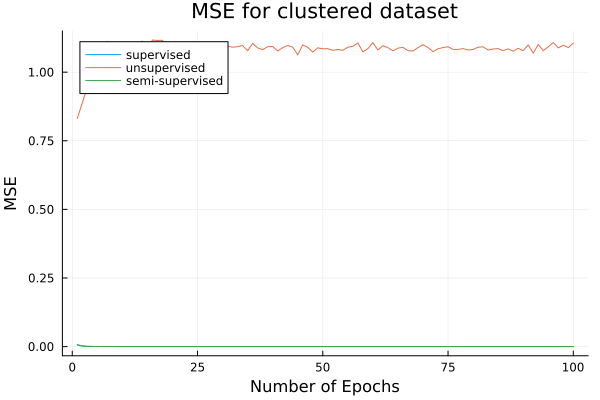

In [6]:
# results of 1. experiment
plot_loss_history(supervised_test_loss_hist; label="supervised")
plot_loss_history!(unsupervised_test_loss_hist; label="unsupervised")
plot_loss_history!(semisupervised_test_loss_hist; label="semi-supervised")
title!("MSE for clustered dataset")
xlabel!("Number of Epochs")
ylabel!("MSE")

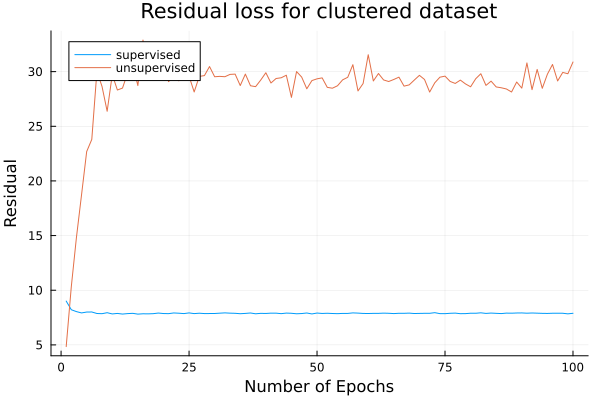

In [7]:
plot_loss_history(res_sup; label="supervised")
plot_loss_history!(res_unsup; label="unsupervised")
title!("Residual loss for clustered dataset")
xlabel!("Number of Epochs")
ylabel!("Residual")

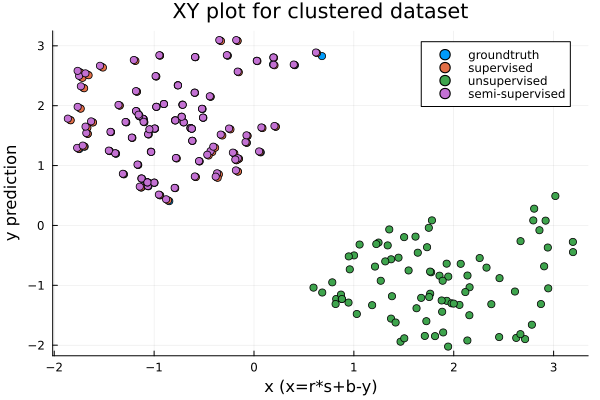

In [8]:
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
scatter(compute_x_from_y.(test_in_rec[1,:],test_in_rec[2,:],vec(test_out_rec)), vec(test_out_rec), label="groundtruth") # reconstruct
plot_xy(supervised_model, test_in, test_out, test_in_t, test_out_t; label="supervised") # reconstruct inside plot xy
plot_xy(unsupervised_model, test_in, test_out, test_in_t, test_out_t; label="unsupervised")
plot_xy(semisupervised_model, test_in, test_out, test_in_t, test_out_t; label="semi-supervised")
title!("XY plot for clustered dataset")
xlabel!("x (x=r*s+b-y)")
ylabel!("y prediction")

# Learnings of 1. Experiment
- Unsupervised training can converge to a true solution
- Unsupervised training is also unguided, it depends on initialization of the parameters to which solution the Network converges, if at all.
- Unsupervised is only superior to Supervised when clustering is not available: more compute while training, unguided
- Semi-Supervised is an option, when a preferred solution exists: less data generation imaginable, guiding of Unsupervised training

# Explanation of 2. Experiment
For the second experiment, the only difference to the first is that **no clustering** is done.

In [9]:
# preparation of 2. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true) #???

hidden_width = 100
model = Flux.Chain(
  Flux.Dense(nInputs, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, nOutputs)
)
opt = Flux.Adam(1e-4)
epochs = 100

100

In [10]:
# 2. experiment
supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs)
unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs)
semisupervised_model, semisupervised_test_loss_hist, semisupervised_time = trainModelSemisupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs, h1=0.8, h2=0.2)

(Chain(Dense(2 => 100, relu), Dense(100 => 100, relu), Dense(100 => 1)), Any[0.12470586f0, 0.11657534f0, 0.11685313f0, 0.112333775f0, 0.12031725f0, 0.11729118f0, 0.117828086f0, 0.1157358f0, 0.11253074f0, 0.10869748f0  …  0.101358555f0, 0.104601584f0, 0.10687345f0, 0.105488084f0, 0.10371171f0, 0.10601225f0, 0.10749523f0, 0.108461335f0, 0.10679477f0, 0.1028207f0], 18.060648202896118)

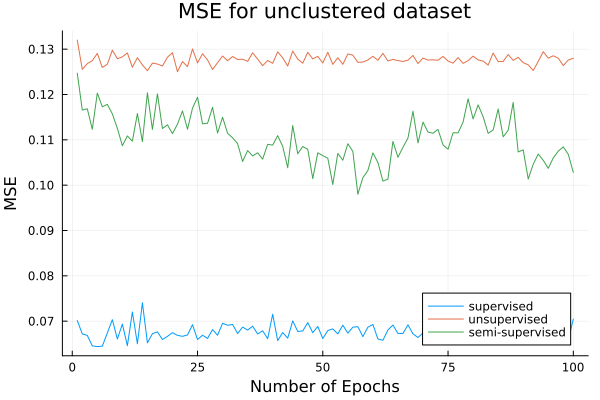

In [11]:
# results of 2. experiment
plot_loss_history(supervised_test_loss_hist; label="supervised")
plot_loss_history!(unsupervised_test_loss_hist; label="unsupervised")
plot_loss_history!(semisupervised_test_loss_hist; label="semi-supervised")
title!("MSE for unclustered dataset")
xlabel!("Number of Epochs")
ylabel!("MSE")

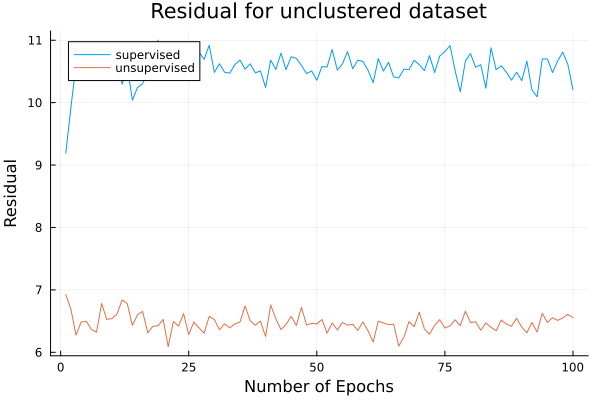

In [12]:
plot_loss_history(res_sup; label="supervised")
plot_loss_history!(res_unsup; label="unsupervised")
title!("Residual for unclustered dataset")
xlabel!("Number of Epochs")
ylabel!("Residual")

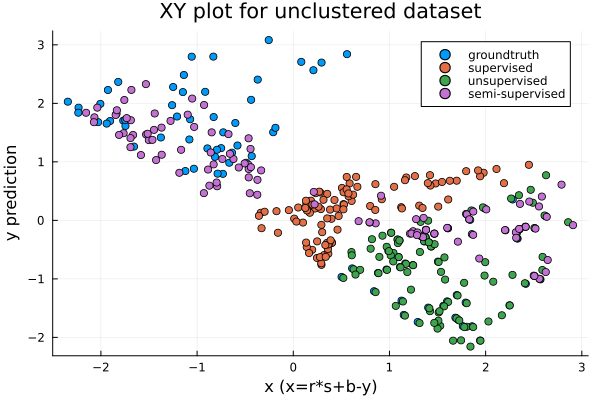

In [13]:
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
scatter(compute_x_from_y.(test_in_rec[1,:],test_in_rec[2,:],vec(test_out_rec)), vec(test_out_rec), label="groundtruth")
plot_xy(supervised_model, test_in, test_out, test_in_t, test_out_t; label="supervised") # reconstruct inside plot xy
plot_xy(unsupervised_model, test_in, test_out, test_in_t, test_out_t; label="unsupervised")
plot_xy(semisupervised_model, test_in, test_out, test_in_t, test_out_t; label="semi-supervised")
title!("XY plot for unclustered dataset")
xlabel!("x (x=r*s+b-y)")
ylabel!("y prediction")

# Learnings of 2. Experiment
- Supervised cant converge on ambigous data, averaging multiple modes
- Unsupervised can converge on ambigous data
- Semi-Supervised needs tuning of hyperparameters to converge, could be trained?
- loss values can be misleading

# Explanation of 3. Experiment
For the third experiment, the **training time of Supervised and Unsupervised** are compared. Both methods are trained for 10, 100 and 1000 epochs and the training time is tracked and compared.

In [14]:
# preparation of 3. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true)

hidden_width = 100
model = Flux.Chain(
  Flux.Dense(nInputs, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, nOutputs)
)
opt = Flux.Adam(1e-4)

epoch_range = [10,100,1000]
gen_unsupervised_data_time = 0.05 # seconds for 1000 datapoints
gen_supervised_data_time = 25 # seconds for 1000 datapoints

25

In [15]:
# 3. experiment unsupervised
full_unsupervised_test_loss_hist = []
full_res_unsupervised_test_loss_hist = []
full_unsupervised_train_time_hist = []
for n_epochs in epoch_range
  unsupervised_model, unsupervised_test_loss_hist, res_unsupervised_test_loss_hist,  unsupervised_time = trainModelUnsupervised(
    deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=n_epochs
    )
    push!(full_unsupervised_test_loss_hist, unsupervised_test_loss_hist[end])
    push!(full_res_unsupervised_test_loss_hist, res_unsupervised_test_loss_hist[end])
    push!(full_unsupervised_train_time_hist, unsupervised_time)
end

In [16]:
# 3. experiment supervised
full_supervised_test_loss_hist = []
full_res_supervised_test_loss_hist = []
full_supervised_train_time_hist = []
for n_epochs in epoch_range
  supervised_model, supervised_test_loss_hist, res_supervised_test_loss_hist, supervised_time = trainModelSupervised(
    deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu;epochs=n_epochs
    )
    push!(full_supervised_test_loss_hist, supervised_test_loss_hist[end])
    push!(full_res_supervised_test_loss_hist, res_supervised_test_loss_hist[end])
    push!(full_supervised_train_time_hist, supervised_time)
end

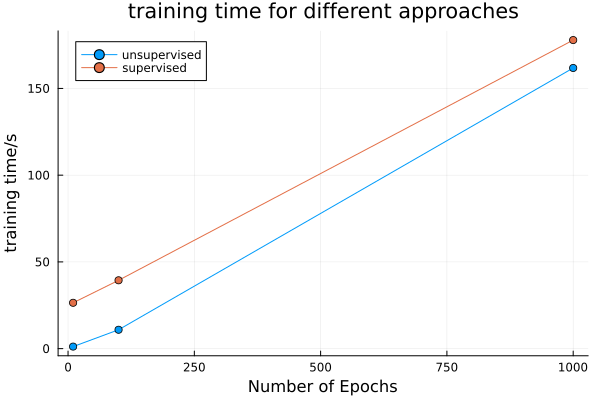

In [17]:
# results of 3. experiment
plot_loss_history(full_unsupervised_train_time_hist .+ gen_unsupervised_data_time, epoch_range; label="unsupervised", marker = :circle)
plot_loss_history!(full_supervised_train_time_hist .+ gen_supervised_data_time, epoch_range; label="supervised", marker = :circle)
title!("training time for different approaches")
xlabel!("Number of Epochs")
ylabel!("training time/s")

# Learnings of 3. Experiment
- training time increases linearly with number of epochs
- unsupervised data generation is ~500 times faster than supervised data generation

# Explanation of 4. Experiment
In the fourth experiment, Unsupervised training is compared for **different batchsizes**, namely 1 and 8.

In [18]:
# preparation of 4. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader_1 = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true)
dataloader_8 = Flux.DataLoader((train_in, train_out), batchsize=8, shuffle=true)

hidden_width = 100
model = Flux.Chain(
  Flux.Dense(nInputs, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, nOutputs)
)
opt = Flux.Adam(1e-4)
epochs = 100

Adam(0.0001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [19]:
# 4. experiment
unsupervised_model_1, unsupervised_test_loss_hist_1, res_unsupervised_test_loss_hist_1,  unsupervised_time_1 = trainModelUnsupervised(
    deepcopy(model), deepcopy(opt), dataloader_1, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs
    )

unsupervised_model_8, unsupervised_test_loss_hist_8, res_unsupervised_test_loss_hist_8,  unsupervised_time_8 = trainModelUnsupervised(
  deepcopy(model), deepcopy(opt), dataloader_8, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs
  )

(Chain(Dense(2 => 100, relu), Dense(100 => 100, relu), Dense(100 => 1)), Any[0.22092603f0, 0.1267864f0, 0.099947825f0, 0.09123662f0, 0.08002122f0, 0.07356585f0, 0.07285175f0, 0.07257151f0, 0.07276949f0, 0.07066566f0  …  0.06010309f0, 0.06208928f0, 0.06816346f0, 0.07339612f0, 0.07196034f0, 0.07161831f0, 0.07135358f0, 0.07258366f0, 0.06655659f0, 0.06424984f0], Any[64.47873176419718, 13.82482571873159, 6.628801530106106, 5.043018962856116, 3.5173195730642637, 2.9049114021805935, 2.845137586246139, 2.8594163087475737, 2.8648944349937744, 2.7668536427901063  …  2.8217463195964556, 2.936239197061257, 3.5253802072757874, 4.118742589677572, 3.9774721030450397, 3.9729321887216305, 3.901760097526372, 4.035433283199833, 3.247521815167051, 3.0683766717027994], 1.4631896018981934)

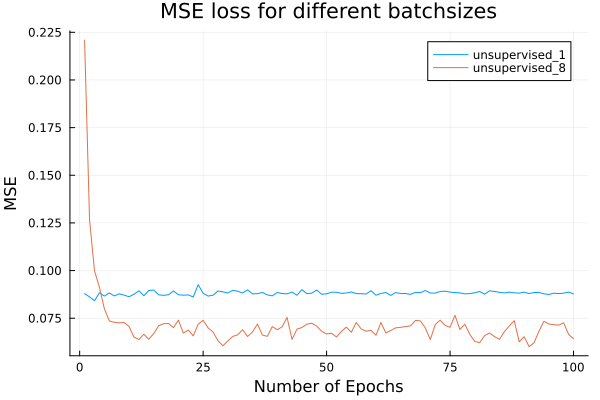

In [20]:
# results of 4. experiment
plot_loss_history(unsupervised_test_loss_hist_1; label="unsupervised_1")
plot_loss_history!(unsupervised_test_loss_hist_8; label="unsupervised_8")
title!("MSE loss for different batchsizes")
xlabel!("Number of Epochs")
ylabel!("MSE")

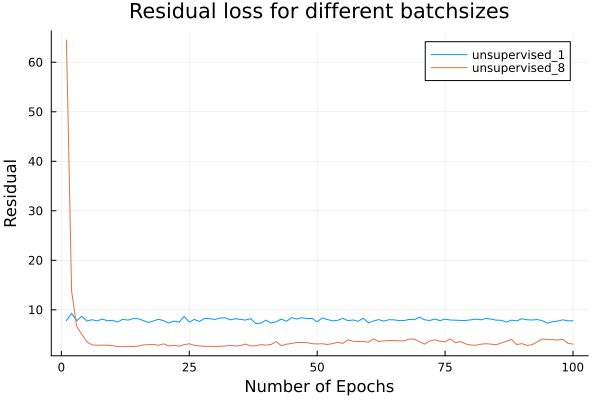

In [21]:
plot_loss_history(res_unsupervised_test_loss_hist_1; label="unsupervised_1")
plot_loss_history!(res_unsupervised_test_loss_hist_8; label="unsupervised_8")
title!("Residual loss for different batchsizes")
xlabel!("Number of Epochs")
ylabel!("Residual")

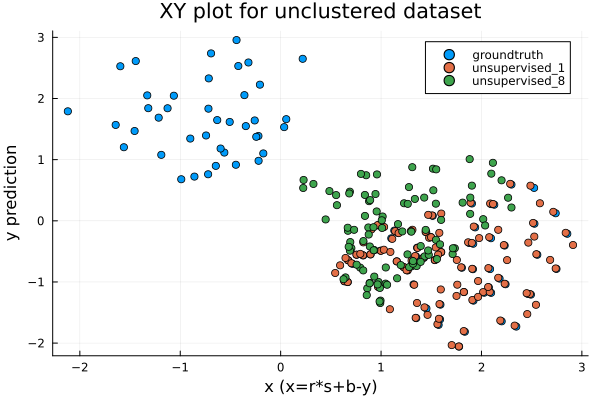

In [22]:
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
scatter(compute_x_from_y.(test_in_rec[1,:],test_in_rec[2,:],vec(test_out_rec)), vec(test_out_rec), label="groundtruth")
plot_xy(unsupervised_model_1, test_in, test_out, test_in_t, test_out_t; label="unsupervised_1")
plot_xy(unsupervised_model_8, test_in, test_out, test_in_t, test_out_t; label="unsupervised_8")
title!("XY plot for unclustered dataset")
xlabel!("x (x=r*s+b-y)")
ylabel!("y prediction")

# Learnings of 4. Experiment
- Unsupervised is probably useless cause bigger batchsize leads to problems (reason could be wrong gradient comp)

# IEEE14 Unsupervised
Now Unsupervised is investigated in a **high dimensional scenario** with 15 inputs and 110 outputs. The loss on test data is tracked and the model predictions are plotted in 3D using PCA. In addition to Supervised, Unsupervised and Semi-Supervised, a Two-Step training procedure is tested which trains Unsupervised for the first half of epochs and Supervised with freezed layers for second half of epochs.

In [23]:
using MultivariateStats
include("trainTwoStep.jl")

trainTwoStep (generic function with 1 method)

In [59]:
# IEEE14 residual


fileName = "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/IEEE_14_Buses_1500/data/eq_1403.csv"
nInputs = 16
nOutputs = 110


comp, fmu, profilinginfo, vr, row_value_reference, eq_num, sys_num = prepare_fmu(
  "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/IEEE_14_Buses_1500/IEEE_14_Buses.interface.fmu",
  "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/IEEE_14_Buses_1500/profilingInfo.bson",
  "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/IEEE_14_Buses_1500/temp-profiling/IEEE_14_Buses.c")

# 1. some UNAMBIGOUS dataset and train all methods for performance
# prepare train and test data
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)

┌ Warning: No variable named 'time' found.
└ @ FMIImport /home/fbrandt3/.julia/packages/FMIImport/7xJzL/src/FMI2/convert.jl:141


(Float32[0.20291102 0.5479763 … 0.35473603 0.18024702; 0.31925893 0.32127002 … 0.3288406 0.32900754; … ; 1.2298079 1.2408832 … 1.3128479 1.2556667; -0.35612133 -0.36569476 … -0.33373904 -0.35560393], Float32[-0.06222606 -0.06464814 … -0.055507243 -0.0721958; 0.03468209 0.034345634 … 0.03478875 0.035382472; … ; 0.96437764 0.9575849 … 0.97092086 0.97681904; -0.39538282 -0.38963562 … -0.39565477 -0.3838837], Float32[0.015167863 0.0235648 … 1.0190227 1.0192502; 0.31202778 0.3103383 … 0.33131847 0.3322679; … ; 1.2637771 1.2686672 … 1.3135616 1.2397643; -0.3389823 -0.3307781 … -0.3418552 -0.3621654], Float32[-0.06436538 -0.05015936 … -0.028123572 -0.028659265; 0.034625333 0.034074362 … 0.0265384 0.025749734; … ; 0.9615799 0.9532235 … 0.7439269 0.72230476; -0.38448295 -0.3945252 … -0.26783508 -0.2665669])

In [60]:
train_in

16×1350 adjoint(::Matrix{Float32}) with eltype Float32:
  0.202911      0.547976     0.96558     …   0.354736     0.180247
  0.319259      0.32127      0.316257        0.328841     0.329008
  0.128938      0.123787     0.130837        0.125334     0.125323
  1.0597        1.02621      1.00212         1.01105      1.07047
  0.00814403    0.00864867   0.00712342      0.00520527   0.00493563
  1.29651       1.20358      1.29651     …   1.29295      1.27454
 -0.327038     -0.342395    -0.330757       -0.354904    -0.351814
  1.17812       1.17303      1.08622         1.09132      1.17777
  0.00129184    0.00121909   0.00138672      0.00123364   0.00121363
  0.0924753     0.0935442    0.0985927       0.098478     0.100641
  1.18852       1.26649      1.19709     …   1.25566      1.17805
  0.229113      0.223125     0.227168        0.229556     0.215816
 -0.392994     -0.380564    -0.401523       -0.38251     -0.36094
 -0.000293987  -0.00049577   0.00315058      0.0005742    0.00140415
  1.2

In [61]:
CLUSTER = true
if CLUSTER
  # concat in and out data
  in_data = hcat(train_in, test_in)
  out_data = hcat(train_out, test_out)

  # cluster out data
  cluster_indices, num_clusters = cluster_data(out_data)
  # extract cluster
  cluster_index = 1 #rand(1:num_clusters)
  in_data = extract_cluster(in_data, cluster_indices, cluster_index)
  out_data = extract_cluster(out_data, cluster_indices, cluster_index)
else
  # take time out, probably earlier
  in_data = hcat(train_in, test_in)
  out_data = hcat(train_out, test_out)
end

┌ Warning: The clustering cost increased at iteration #9
└ @ Clustering /home/fbrandt3/.julia/packages/Clustering/tyftt/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #22
└ @ Clustering /home/fbrandt3/.julia/packages/Clustering/tyftt/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #25
└ @ Clustering /home/fbrandt3/.julia/packages/Clustering/tyftt/src/kmeans.jl:191


110×957 Matrix{Float32}:
 -0.0622261  -0.0646481  -0.0477463  …  -0.0578368  -0.0637111  -0.0619729
  0.0346821   0.0343456   0.0347669      0.0347983   0.0348059   0.0343514
  0.129218    0.14826     0.156576       0.131353    0.129418    0.142239
 -0.0885408  -0.108088   -0.116132      -0.0909589  -0.0892475  -0.102255
  0.174186    0.212467    0.218693       0.204964    0.185804    0.190986
  0.0435801   0.0529813   0.0982849  …   0.0518004   0.0945116   0.0860412
  0.881188    0.871975    0.866275       0.874535    0.85752     0.870403
  0.0990815   0.0980394   0.0994259      0.0993898   0.0986493   0.0980872
  0.169428    0.205979    0.201392       0.198672    0.168872    0.176214
 -0.0467654  -0.0463843  -0.04602       -0.0461422  -0.0462574  -0.0460903
  ⋮                                  ⋱               ⋮          
  0.943237    0.928936    0.938528       0.942639    0.940621    0.928705
 -0.393408   -0.386587   -0.383564      -0.386421   -0.383735   -0.383253
 -0.410194   -0.4

In [69]:
# Warning: No variable named 'time' found.
in_data = in_data[2:end,:]  # take time variable out of in data
# and out of the row_value_reference
rvr = []
for i in 2:16
    push!(rvr, row_value_reference[i])
end
rvr = Int64.(rvr)

15-element Vector{Int64}:
  4
  6
  7
 42
 43
 19
 23
 22
  9
 13
 12
 29
 32
 33
 39

In [70]:
# split one cluster into train and test
train_in, train_out, test_in, test_out = split_train_test(in_data, out_data)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=8, shuffle=true)

96-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true, batchsize=8)
  with first element:
  (15×8 Matrix{Float32}, 110×8 Matrix{Float32},)

In [71]:
hidden_width = 100
model = Flux.Chain(
  Flux.Dense(nInputs-1, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, nOutputs)
)

opt = Flux.Adam(1e-4)
epochs = 100

100

In [72]:
unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), 
                                                                                                       deepcopy(opt), 
                                                                                                       dataloader, 
                                                                                                       test_in, 
                                                                                                       test_out, 
                                                                                                       train_in_t, 
                                                                                                       test_in_t, 
                                                                                                       train_out_t, 
                                                                                                       test_out_t, 
                                                                                                       eq_num, 
                                                                                                       sys_num, 
                                                                                                       deepcopy(rvr), 
                                                                                                       deepcopy(fmu); epochs=epochs)

supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), 
                                                                                              deepcopy(opt), 
                                                                                              dataloader, 
                                                                                              test_in, 
                                                                                              test_out, 
                                                                                              train_in_t, 
                                                                                              test_in_t, 
                                                                                              train_out_t, 
                                                                                              test_out_t, 
                                                                                              eq_num, 
                                                                                              sys_num, 
                                                                                              deepcopy(rvr), 
                                                                                              deepcopy(fmu); epochs=epochs)

semisupervised_model, semisupervised_test_loss_hist, semisupervised_time = trainModelSemisupervised(deepcopy(model), 
                                                                                              deepcopy(opt), 
                                                                                              dataloader, 
                                                                                              test_in, 
                                                                                              test_out, 
                                                                                              train_in_t, 
                                                                                              test_in_t, 
                                                                                              train_out_t, 
                                                                                              test_out_t, 
                                                                                              eq_num, 
                                                                                              sys_num, 
                                                                                              deepcopy(rvr), 
                                                                                              deepcopy(fmu); epochs=epochs, h1=0.8, h2=0.2)

twost_model, twost_test_loss_hist, twost_time = trainTwoStep(deepcopy(model), 
                                                            deepcopy(opt), 
                                                            dataloader, 
                                                            test_in, 
                                                            test_out, 
                                                            train_in_t, 
                                                            test_in_t, 
                                                            train_out_t, 
                                                            test_out_t, 
                                                            eq_num, 
                                                            sys_num, 
                                                            deepcopy(rvr), 
                                                            deepcopy(fmu); epochs=epochs)

(Chain(Dense(15 => 100, relu), Dense(100 => 100, relu), Dense(100 => 100, relu), Dense(100 => 100, relu), Dense(100 => 110)), Any[0.2286534f0, 1.762378f0, 34.02851f0, 71.68713f0, 94.77817f0, 102.63227f0, 100.12218f0, 123.48815f0, 132.49693f0, 141.17734f0  …  9.00872f0, 8.591305f0, 8.183367f0, 7.7878294f0, 7.4010553f0, 7.0266285f0, 6.661458f0, 6.3072615f0, 5.962401f0, 5.627179f0], 0)

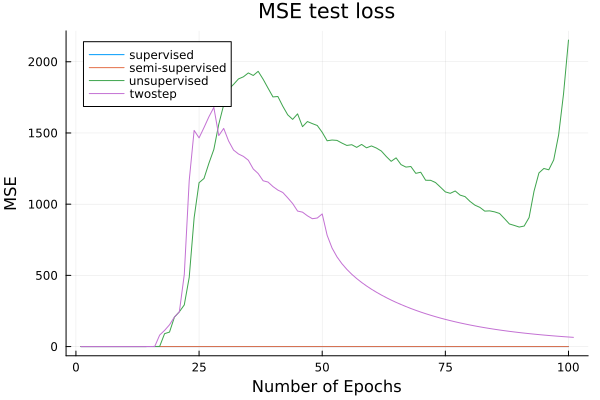

In [52]:
plot_loss_history(supervised_test_loss_hist; label="supervised")
plot_loss_history!(semisupervised_test_loss_hist; label="semi-supervised")
plot_loss_history!(unsupervised_test_loss_hist; label="unsupervised")
plot_loss_history!(twost_test_loss_hist; label="twostep")
title!("MSE test loss")
xlabel!("Number of Epochs")
ylabel!("MSE")

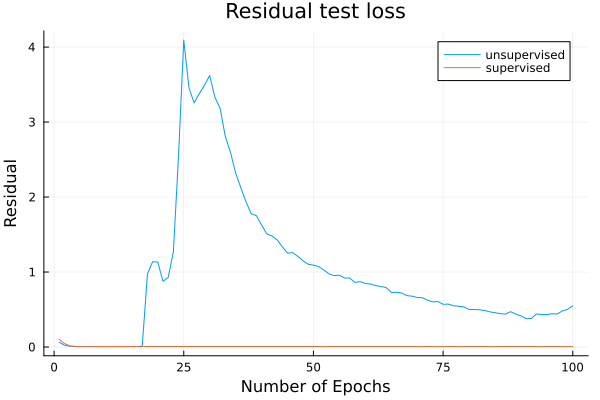

In [53]:
plot_loss_history(res_unsup; label="unsupervised")
plot_loss_history!(res_sup; label="supervised")
title!("Residual test loss")
xlabel!("Number of Epochs")
ylabel!("Residual")

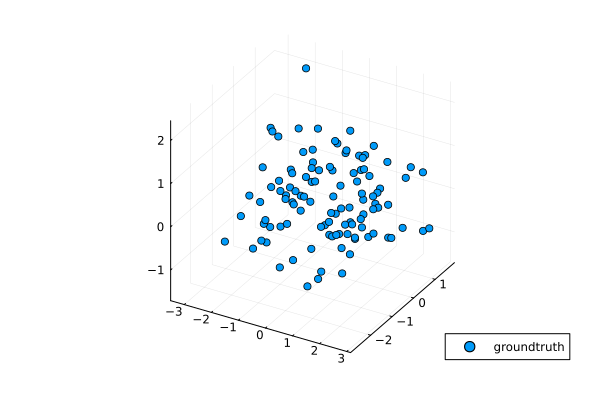

In [54]:
M1 = fit(PCA, test_out; maxoutdim=3)
O1 = predict(M1, test_out)
scatter(O1[1,:],O1[2,:],O1[3,:], label="groundtruth")

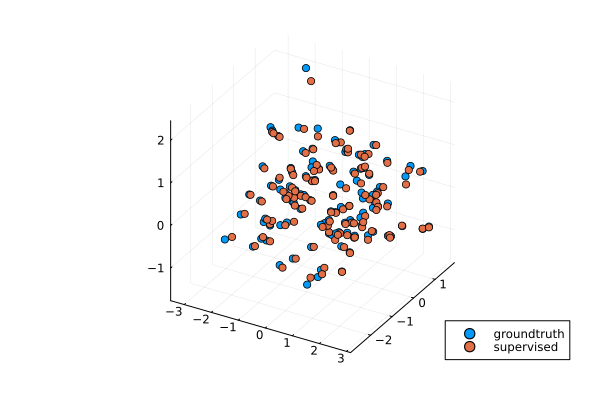

In [55]:
pred3 = supervised_model(test_in)
O3 = predict(M1, pred3)
scatter!(O3[1,:],O3[2,:],O3[3,:], label="supervised")

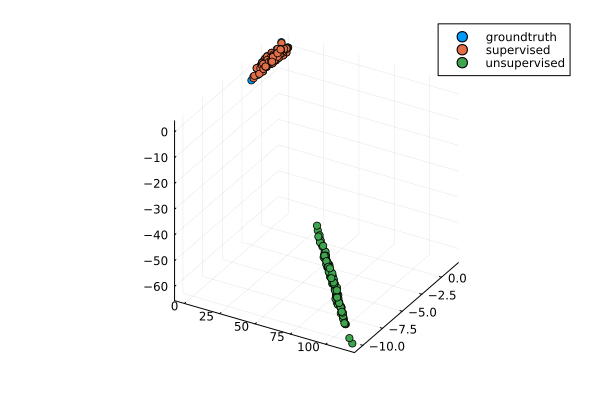

In [56]:
pred2 = unsupervised_model(test_in)
O2 = predict(M1, pred2)
scatter!(O2[1,:],O2[2,:],O2[3,:], label="unsupervised")

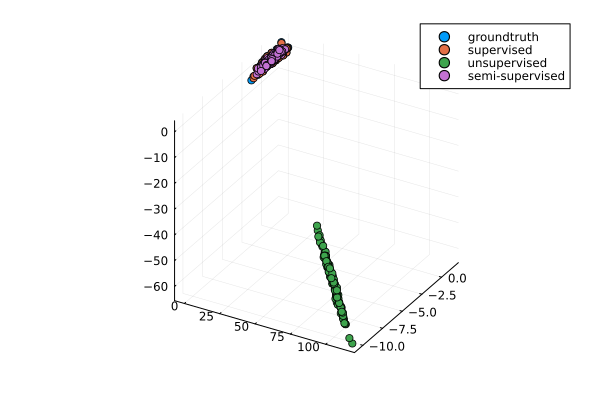

In [57]:
pred4 = semisupervised_model(test_in)
O4 = predict(M1, pred4)
scatter!(O4[1,:],O4[2,:],O4[3,:], label="semi-supervised")

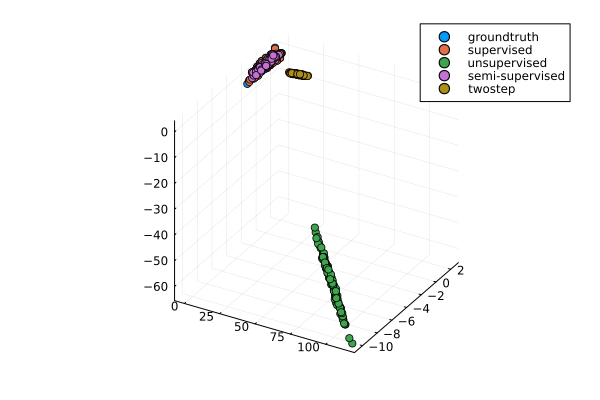

In [58]:
pred5 = twost_model(test_in)
O5 = predict(M1, pred5)
scatter!(O5[1,:],O5[2,:],O5[3,:], label="twostep")

# Learnings of IEEE14
- Unsupervised in higher dimension does not seem to work well, because it does not converge.

# Results/Conclusion of whole Notebook
- If everything is implemented correctly: Unsupervised works in small dimensions but not in higher dimensions.